In [1]:
# Parameters
file = "mice_F_post.csv"  # default value, will be overridden by papermill
scale = 1
TIME_UNIT = "days"
nbins = 150
folder = None
Products_folder = None
datasets_folder = None
seed_folder =None
subfolder = None


In [2]:
# Parameters
file = "Jack_Russell_vetCompass_post.csv"
scale = 1
TIME_UNIT = "years"
nbins = 100
subfolder = "DOGS"
folder = "/Users/navehr/Dropbox/naveh/weizmann/uri alon/aging/code_3/baysian02/posterior_csvs_baysian01"
Products_folder = "/Users/navehr/Dropbox/naveh/weizmann/uri alon/aging/code_3/baysian02/final_baysian_01"
datasets_folder = "/Users/navehr/Dropbox/naveh/weizmann/uri alon/aging/code_3/baysian02/datasets_baysian_01"
seed_folder = "/Users/navehr/Dropbox/naveh/weizmann/uri alon/aging/code_3/baysian02/seeds_baysian_01"


In [3]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import os
#change current working directory to the parent directory
if 'changed' not in globals():
    os.chdir("..")
    global changed
    changed = True
import numpy as np
from SRtools import sr_mcmc as srmc
import argparse
from SRtools import config_lib as cl
from SRtools import deathTimesDataSet as dtds
import ast
from SRtools import readResults as rr
import corner
import matplotlib.pyplot as plt
import matplotlib
from SRtools import SRmodellib as sr
from SRtools import SRmodellib_lifelines as srl
from SRtools import samples_utils as su
from SRtools import SR_hetro as srh
from SRtools import joint_posterior as jp
import emcee

In [4]:
print(os.getcwd())


/Users/navehr/Dropbox/naveh/weizmann/uri alon/aging/code_3


In [5]:
# folder = os.path.abspath(os.path.join(os.getcwd(), 'posterior_csvs_baysian01'))
# Products_folder = os.path.abspath(os.path.join(os.getcwd(), 'final_baysian_01'))
base_products_folder = Products_folder

if subfolder is not None:
    folder = os.path.abspath(os.path.join(folder, subfolder))
    results_path = os.path.join(Products_folder,'results_csvs',subfolder,file.replace('_post.csv','.csv'))
    path_days = os.path.join(Products_folder,'results_csvs',subfolder,file.replace('_post.csv','_days.csv'))
    Products_folder = os.path.abspath(os.path.join(Products_folder, subfolder))
    # datasets_folder = os.path.abspath(os.path.join(datasets_folder, subfolder))
    # seed_folder = os.path.abspath(os.path.join(seed_folder, subfolder))
    path = os.path.join(folder, file)
else:
    path = os.path.join(folder, file)
    results_path = os.path.join(Products_folder,'results_csvs',file.replace('_post.csv','.csv'))
    path_days = os.path.join(Products_folder,'results_csvs',file.replace('_post.csv','_days.csv'))
# Create directory for results_path if it doesn't exist
os.makedirs(os.path.dirname(results_path), exist_ok=True)

if TIME_UNIT == 'days':
    scale = None
elif TIME_UNIT == 'hours':
    scale = 1/24
elif TIME_UNIT == 'years':
    scale = 365
elif TIME_UNIT == 'generations':
    scale = 1/8
else:
    raise ValueError(f"Invalid TIME_UNIT: {TIME_UNIT}")

parallel = True
override = False

print(f"Loading file from: {path}")

Loading file from: /Users/navehr/Dropbox/naveh/weizmann/uri alon/aging/code_3/baysian02/posterior_csvs_baysian01/DOGS/Jack_Russell_vetCompass_post.csv


In [6]:
post = su.Posterior.load_from_file(path)

In [7]:
config =post.config_params

In [8]:
#get the name of current folder:
current_folder = os.path.basename(os.getcwd())

In [9]:
nsteps = config.get('nsteps')
npeople = config['npeople']
t_end = config['t_end']
nwalkers = config['nwalkers']
nsteps = config['nsteps']
num_mcmc_steps = config['n_mcmc_steps']
metric = config['metric']
time_range = config['time_range']
time_step_multiplier = config['time_step_multiplier']
data_file = config['data_file']
seed_file = config['seed_file']
variations = config['variations']
prior = config['prior']
transform = config['transform']
index = config['index']
external_hazard = ast.literal_eval(config['external_hazard'])
hetro = config.get('hetro', False)

#keep only the path after datasets/ in data_file and make it datasets_baysian_01/data_file.
#keep only the path after seeds/ in data_file and make it seeds_baysian_01/data_file.
# Extract the path after datasets/ and seeds/
data_file = os.path.join(datasets_folder, data_file.split('datasets/')[-1])
seed_file = os.path.join(seed_folder, seed_file.split('seeds/')[-1])



In [10]:
ds = dtds.dsFromFile(data_file)
ds.external_hazard = external_hazard
seed_res = rr.readResultsFile(seed_file)
res_df = seed_res[1]
seed = rr.getTheta(res_df)
if transform:
    seed_trans = srmc.transform(seed)

Reading Jack_Russell


In [11]:
if not isinstance(post, jp.JointPosterior):
    samples_trans =post.samples
    lnprobs = post.lnprobs
    best_theta_trans = post.best_raw_sample()
else:
    best_theta_trans = post.get_mode()

if len(best_theta_trans) == 5:
    external_hazard = best_theta_trans[-1]
    ds.external_hazard = external_hazard

In [12]:
if not isinstance(post, jp.JointPosterior):
    samples =np.array([srmc.inv_transform(sample) for sample in samples_trans])
best_theta = srmc.inv_transform(best_theta_trans)

# # 1. Density coner plot
A sample is 1 parameter set scanned.
For the corner plot below, the quantiles (represented by the solid lines) are 0.16,0.5,0.84 of the samples. Dots represent individual samples (outside the line surrounding 0.84 of the samples)
The parameter search is performed in the transformed space of $x_c/\eta$, $\beta/\eta$, $x_c^2/\epsilon$, $x_c$ but we also show the regular parameters


(16,)


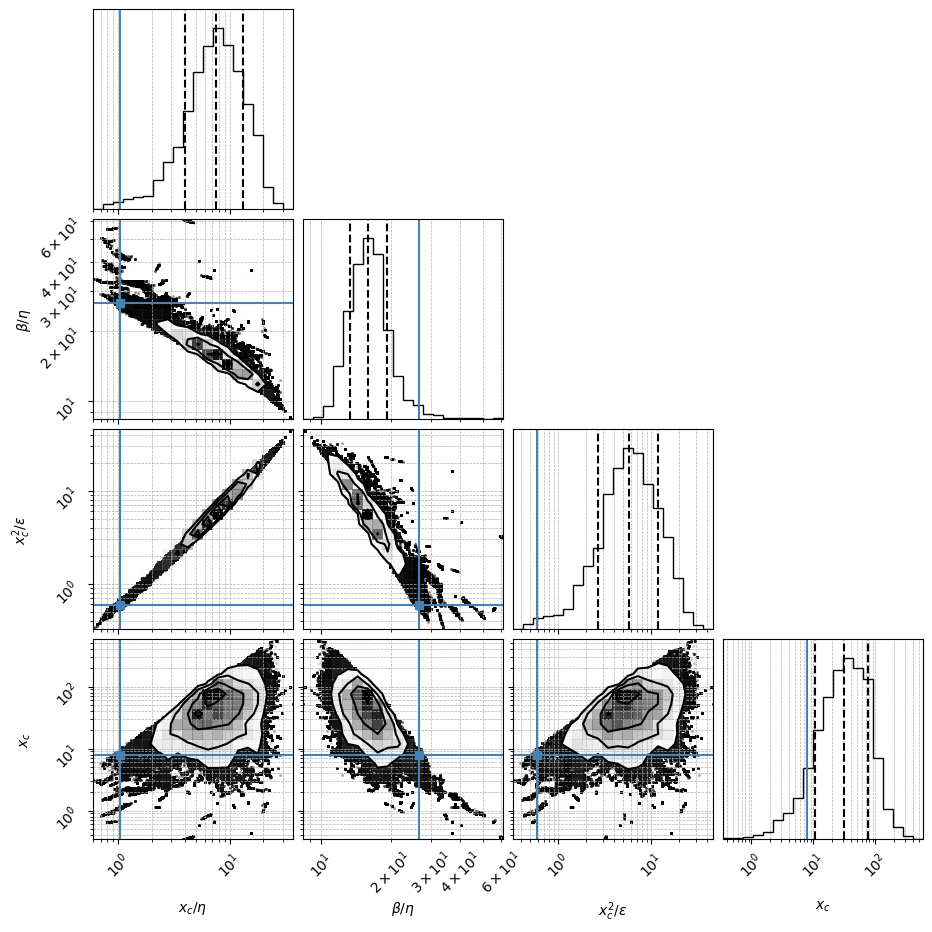

In [13]:
if not isinstance(post, jp.JointPosterior):
    fig = corner.corner(samples_trans, labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$","EextH"], axes_scale='log',quantiles=[0.16, 0.5, 0.84], truths=best_theta_trans)
    axes=fig.get_axes()
    print(np.shape(axes))
    for ax in axes:
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)

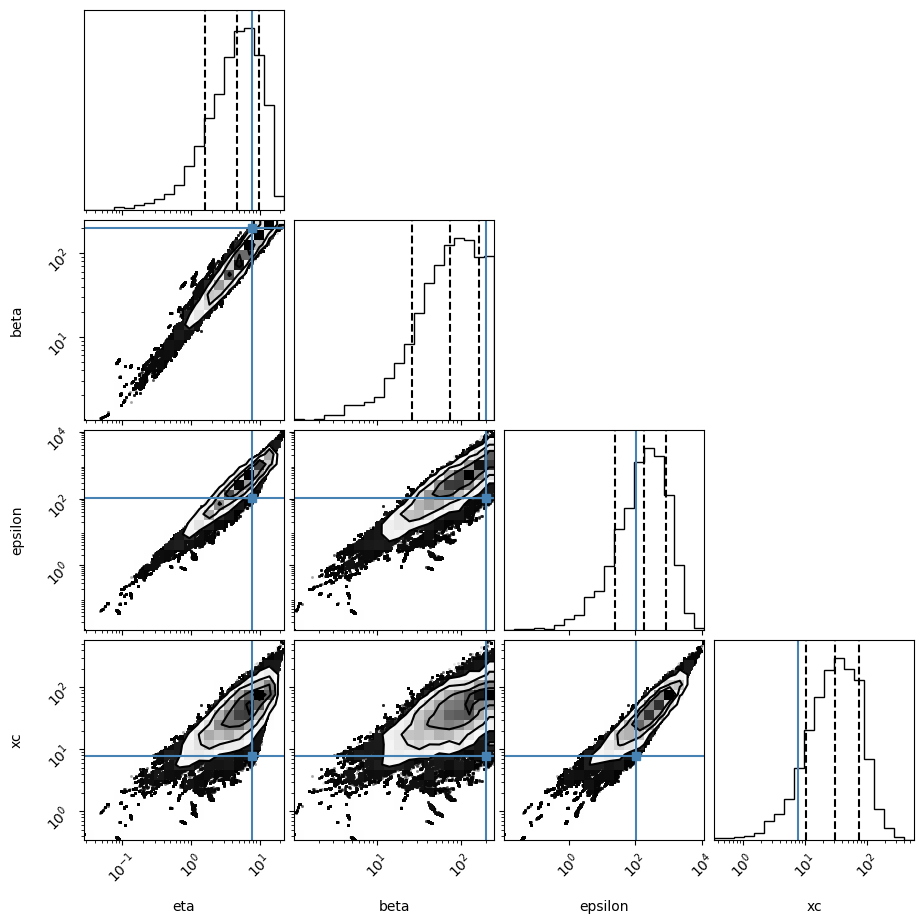

In [14]:
if not isinstance(post, jp.JointPosterior):
    fig = corner.corner(samples, labels=['eta','beta','epsilon','xc','Hext'],axes_scale='log',quantiles=[0.16, 0.5, 0.84], truths=best_theta)

# 2. Heat map corner plot of raw  samples
This plot shows all the raw sample points and their lnprobability

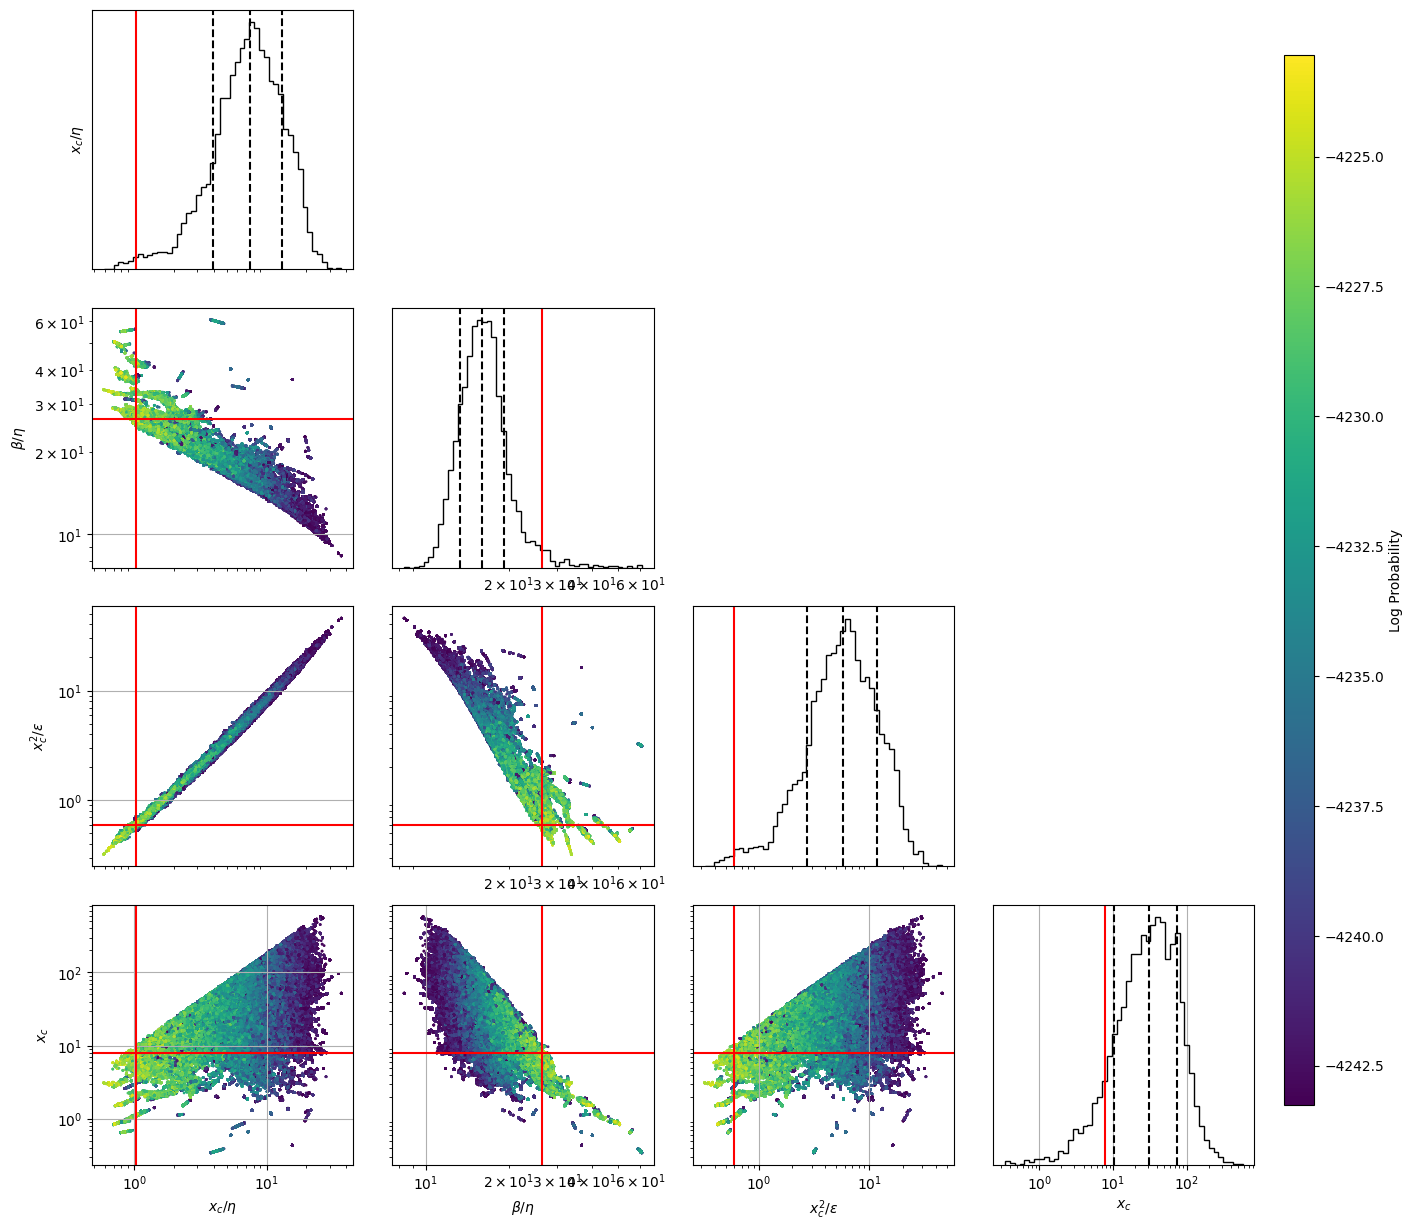

In [15]:
if not isinstance(post, jp.JointPosterior):
    fig,ax=srmc.custom_corner(samples_trans,lnprobs, truths= best_theta_trans, labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$","ExtH"], show_color_bar=True)

# 3. Posterior distributions of parameters

1d marginalizations of posterior distributions. we use a grid of size nbins=100-150

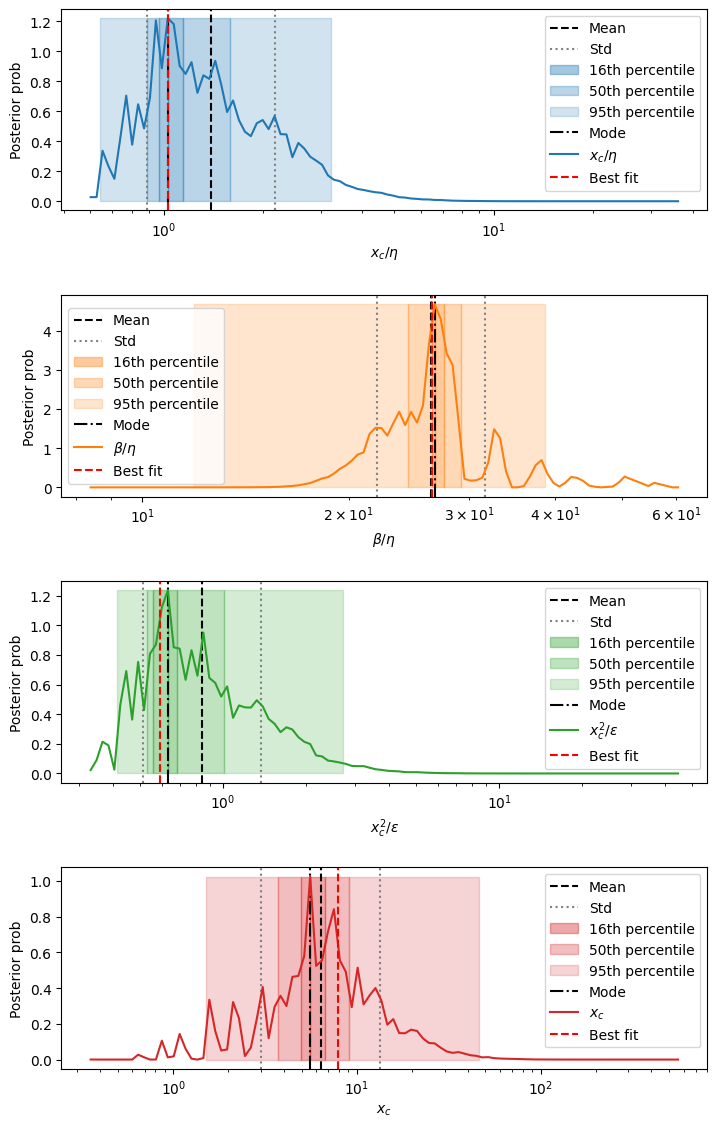

In [16]:
post.plot_1d_posteriors(labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$","ExtH"], truths=best_theta_trans,scale='log',show_ln_prob=False,smooth_mode=False)

2D marginalizations of posterior distributions 

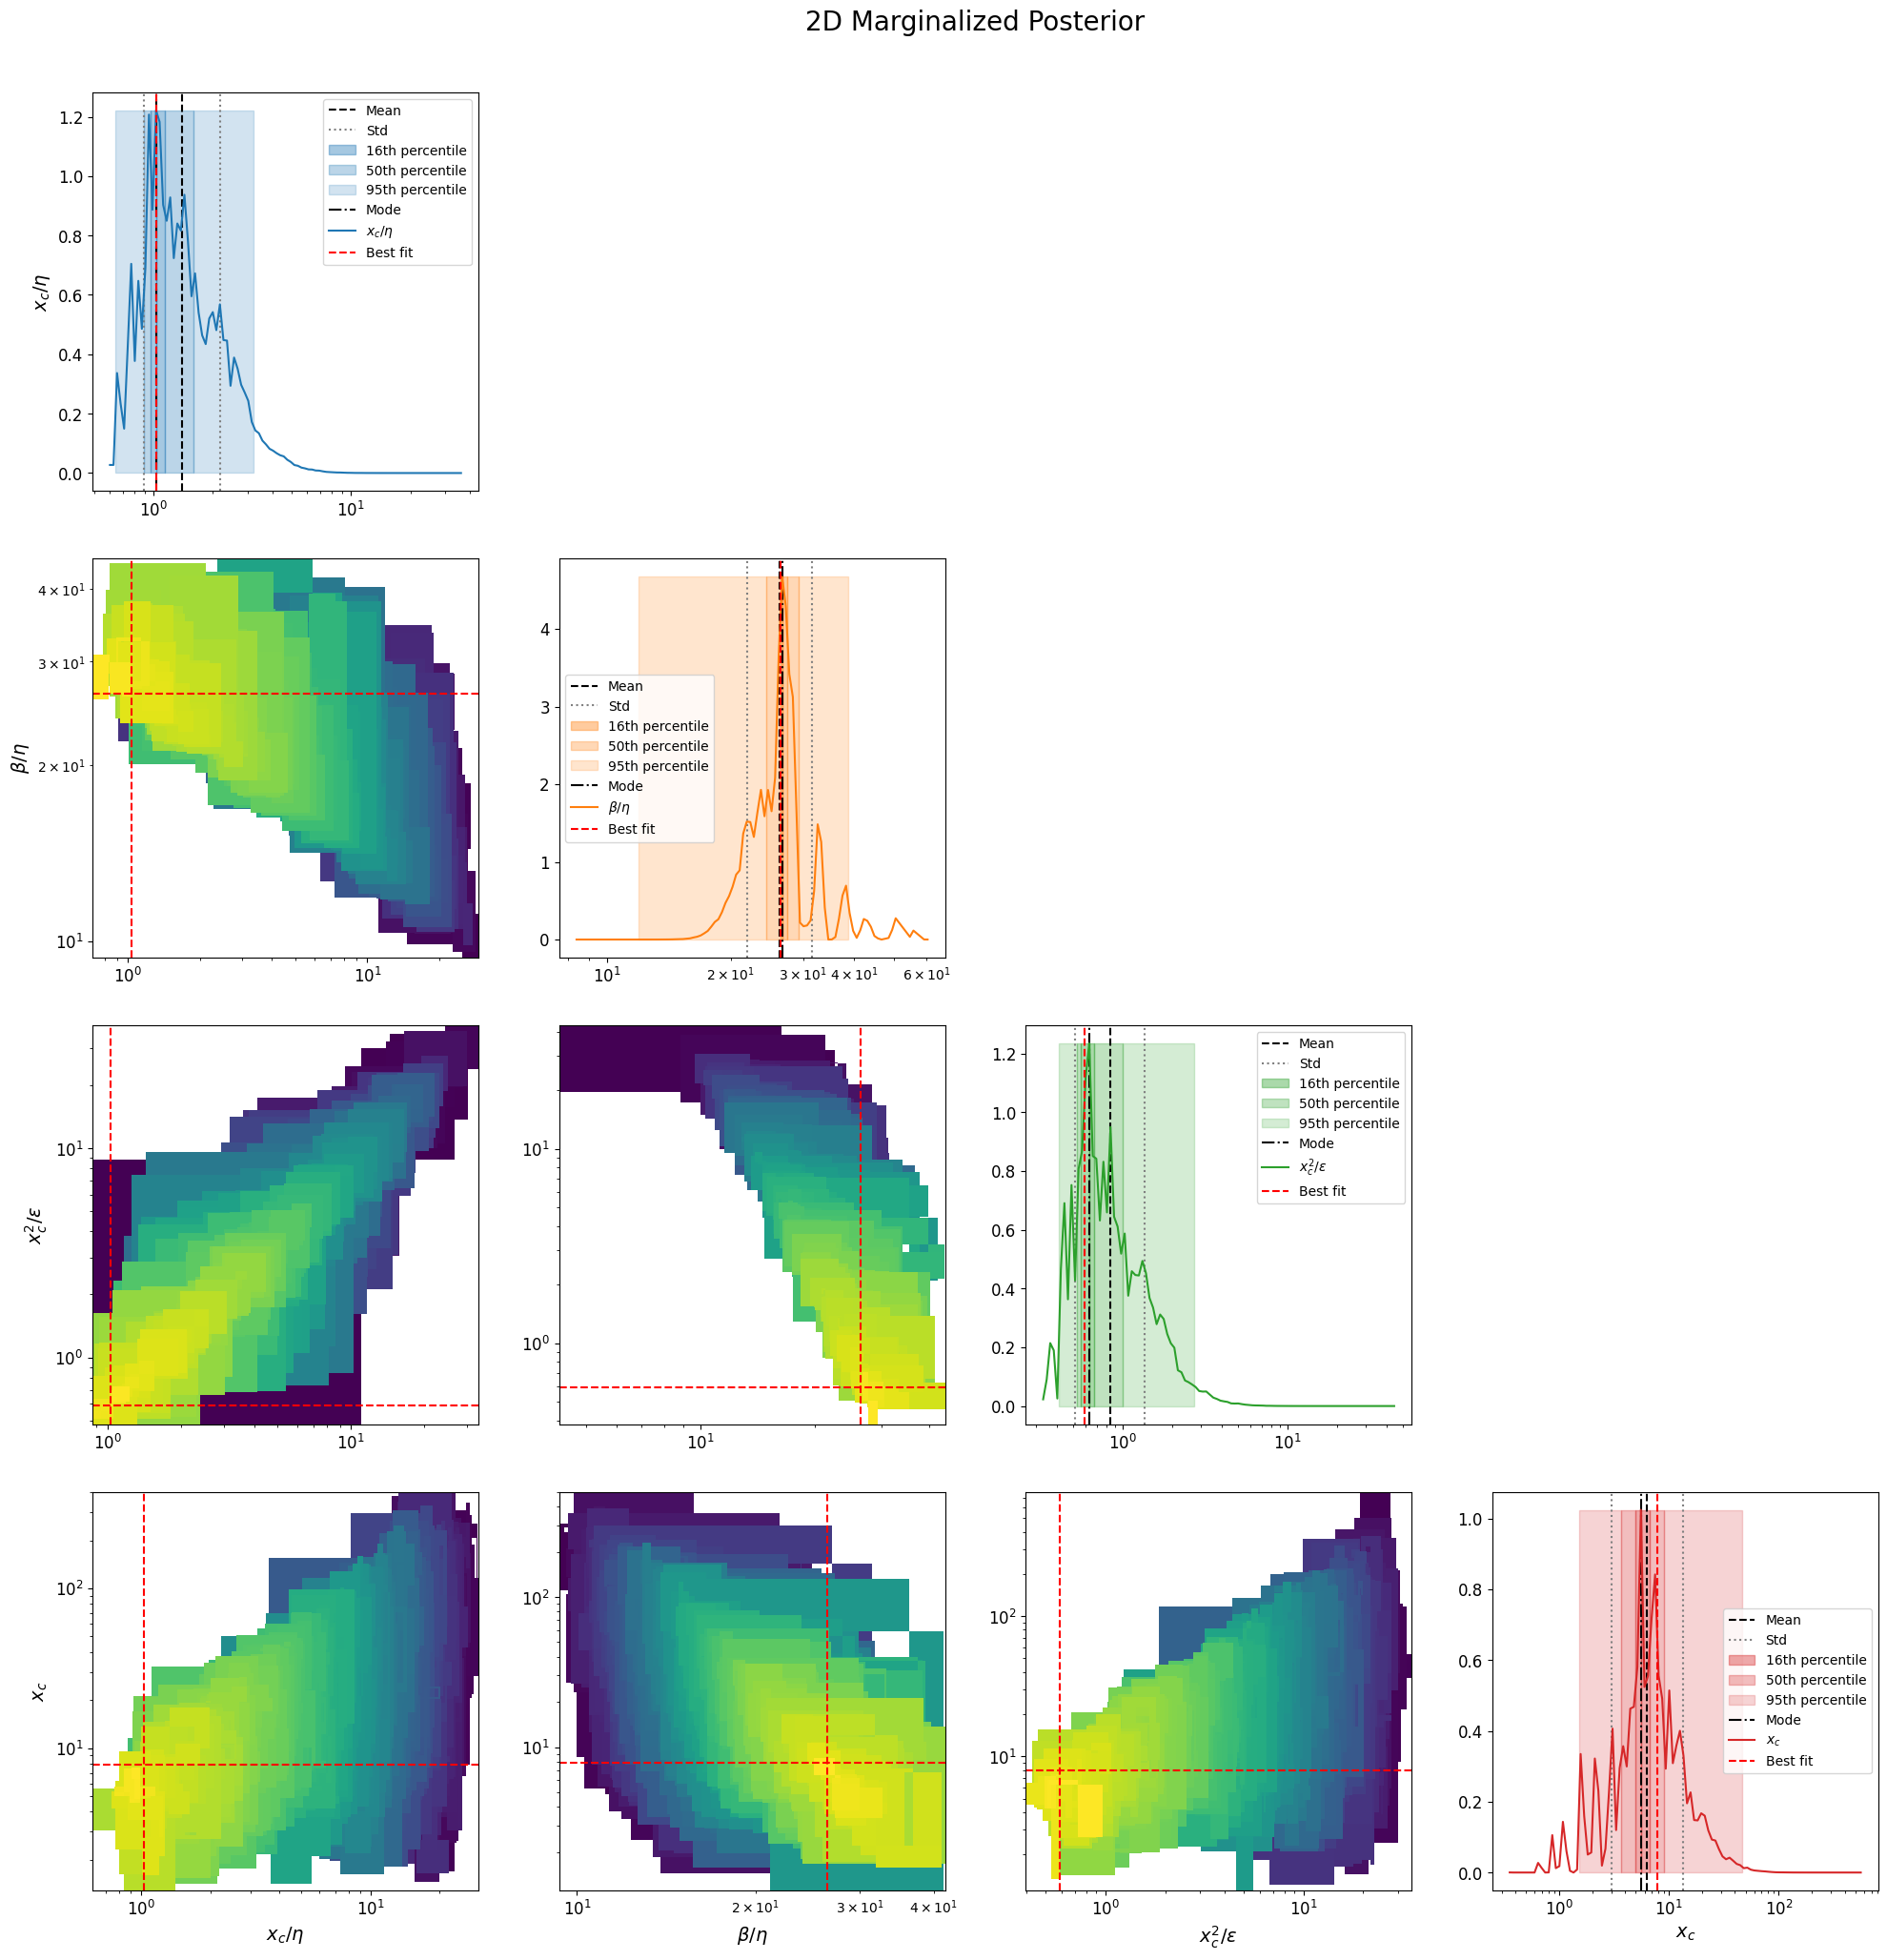

In [17]:
_=post.corner_plot(labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$","ExtH"], truths=best_theta_trans,scale='log',show_ln_prob=False,norm='log',plot_type="pcolormesh")

In [18]:
post.bins =None
fig =post.plot_posterior3D_interactive([0,1,2],labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$","ExtH"], truths=np.log(best_theta_trans),truth_label="Best fit" )
# Save the figure using matplotlib's savefig instead of plotly's write_image
fig.show()
# Save the figure as HTML
html_file_name=file.replace('_post.csv','_3D')
html_path = os.path.join(base_products_folder, 'html_3d_plots', f'{html_file_name}.html')
# Create directory if it doesn't exist
os.makedirs(os.path.dirname(html_path), exist_ok=True)
fig.write_html(html_path)




In [19]:
best_sim = srh.getSrHetro(best_theta, nsteps=nsteps, npeople=npeople, time_step_multiplier=time_step_multiplier, t_end=t_end, external_hazard=external_hazard,hetro =hetro,parallel=parallel)

In [20]:
post.bins =nbins
if post.bins is None:
    post.bins =100
post.progress_bar =False

In [21]:
#mkdri of results_path
os.makedirs(os.path.dirname(results_path), exist_ok=True)

In [22]:
df=post.create_posterior_df(filepath=results_path, ds = [best_sim,ds], ds_labels=['best fit','data'])

# path_days = f"{results_path.split('.csv')[0]}_days.csv" if results_path is not None else None
# df_days=post.create_posterior_df(filepath=path_days, ds = [best_sim,ds], ds_labels=['best fit','data'],rescale=365)

In [23]:
#creating a new df with the results in days
if TIME_UNIT is not 'days':
    df_days=post.create_posterior_df(filepath=path_days, ds = [best_sim,ds], ds_labels=['best fit','data'],rescale=scale)
else:
    df_days=df


Rescaling the samples TIME by 365


# 4. Table of results

mode is the marginalized mode,
max_likwlihood is the sample with highest likelihood
mode_overall is the 4D posterior mode


In [24]:
df

,mean,std,mode,percentile_16,percentile_50,percentile_95,max_likelihood,mode_overall
xc/eta,1.391,"[0.778, 0.499]",1.073,"[0.967, 1.142]","[0.891, 1.589]","[0.667, 3.348]",1.034,0.858
beta/eta,26.366,"[5.264, 4.388]",26.703,"[26.438, 27.512]","[23.932, 28.066]","[17.752, 33.575]",26.419,27.462
xc^2/epsilon,0.841,"[0.534, 0.326]",0.63,"[0.585, 0.713]","[0.504, 0.96]","[0.375, 2.34]",0.591,0.488
xc,6.345,"[7.059, 3.341]",6.462,"[5.78, 7.224]","[4.293, 9.727]","[1.895, 27.548]",7.905,6.873
eta,4.414,"[3.653, 1.999]",7.501,"[6.782, 8.296]","[4.239, 8.872]","[1.266, 10.852]",7.647,7.647
beta,118.565,"[83.145, 48.873]",196.168,"[180.604, 225.146]","[129.755, 251.381]","[43.097, 251.381]",202.021,202.021
epsilon,42.555,"[104.146, 30.211]",85.005,"[69.105, 104.564]","[26.292, 120.043]","[4.369, 362.234]",105.766,105.766
sqrt(xc/eta),1.204,"[0.321, 0.254]",1.015,"[0.984, 1.091]","[0.944, 1.287]","[0.816, 1.907]",1.017,0.983
s= eta^0.5*xc^1.5/epsilon,0.731,"[0.244, 0.183]",0.604,"[0.578, 0.649]","[0.53, 0.771]","[0.459, 1.333]",0.581,0.581
beta*xc/epsilon,15.876,"[2.952, 2.489]",15.561,"[15.189, 15.943]","[14.01, 16.466]","[12.312, 22.023]",15.098,15.68


In [25]:
import pandas as pd
import SRtools.utils as ut
summery_csv_base_name='summery'
# Create paths for the three summary CSV files
mode_summary_path = os.path.join(base_products_folder, f'{summery_csv_base_name}_mode.csv')
max_likelihood_summary_path = os.path.join(base_products_folder, f'{summery_csv_base_name}_max_likelihood.csv')
mode_overall_summary_path = os.path.join(base_products_folder, f'{summery_csv_base_name}_mode_overall.csv')
mode_plus_ci_summary_path = os.path.join(base_products_folder, f'{summery_csv_base_name}_mode_plus_ci.csv')

# Get the relevant values from df_days
file_name = os.path.basename(file).replace('_post.csv', '')
mode_values = df_days['mode'].copy()
max_likelihood_values = df_days['max_likelihood'].copy()
mode_overall_values = df_days['mode_overall'].copy()
# Get the 95% confidence intervals from df_days
ci_values = df_days['percentile_95'].copy()
# Convert CI values to string representation
ci_values = ci_values.apply(lambda x: f"[{x[0]}, {x[1]}]" if isinstance(x, (list, tuple, np.ndarray)) else x)



# Add file name as column name
mode_values = pd.DataFrame(mode_values.values, columns=[file_name], index=mode_values.index)
mode_values[f'{file_name} 95% CI'] = ci_values
max_likelihood_values = pd.DataFrame(max_likelihood_values.values, columns=[file_name], index=max_likelihood_values.index)
mode_overall_values = pd.DataFrame(mode_overall_values.values, columns=[file_name], index=mode_overall_values.index)
mode_plus_ci = pd.DataFrame({
    file_name: [f"{mode_values.loc[i, file_name]} [{ci_values.loc[i]}]" for i in mode_values.index]
}, index=mode_values.index)



# Save the data
ut.append_or_create_csv(mode_values, mode_summary_path,override=override)
ut.append_or_create_csv(max_likelihood_values, max_likelihood_summary_path,override=override)
ut.append_or_create_csv(mode_overall_values, mode_overall_summary_path,override=override)
ut.append_or_create_csv(mode_plus_ci, mode_plus_ci_summary_path,override=override)





In [26]:
import pandas as pd
import SRtools.utils as ut

# Create configuration parameters DataFrame
config_params = pd.DataFrame.from_dict(config, orient='index', columns=[file_name])

# Create a new DataFrame with the additional parameters
additional_params = pd.DataFrame({
    file_name: [nbins, seed, seed_trans]
}, index=['nbins', 'seed', 'seed_trans'])

# Concatenate the DataFrames
config_params = pd.concat([config_params, additional_params])

# Save configuration parameters
config_summary_path = os.path.join(base_products_folder, f'All_config.csv')
ut.append_or_create_csv(config_params, config_summary_path, override=True)

In [27]:
#get the theta of the modes of the posterior (from the df) location of indexes eta, beta, epsilon, xc and columen 'mode'

if not isinstance(post, jp.JointPosterior):
    theta_mode_trans = post.get_best_sample_in_mode()
    if len(theta_mode_trans) == 5:
        eh = theta_mode_trans[-1]
    else:
        eh = ds.external_hazard
    sim_mode_trans = srh.getSrHetro(srmc.inv_transform(theta_mode_trans), nsteps=nsteps, npeople=npeople, time_step_multiplier=time_step_multiplier, t_end=t_end, external_hazard=eh,parallel=True,hetro=hetro)


# 5. Fits of simulations to data
best params is the sample with highest likelihood. 
mode trans is the 4D posterior mode in the transformed space of $x_c/\eta$, $\beta/\eta$, $x_c^2/\epsilon$, $x_c$

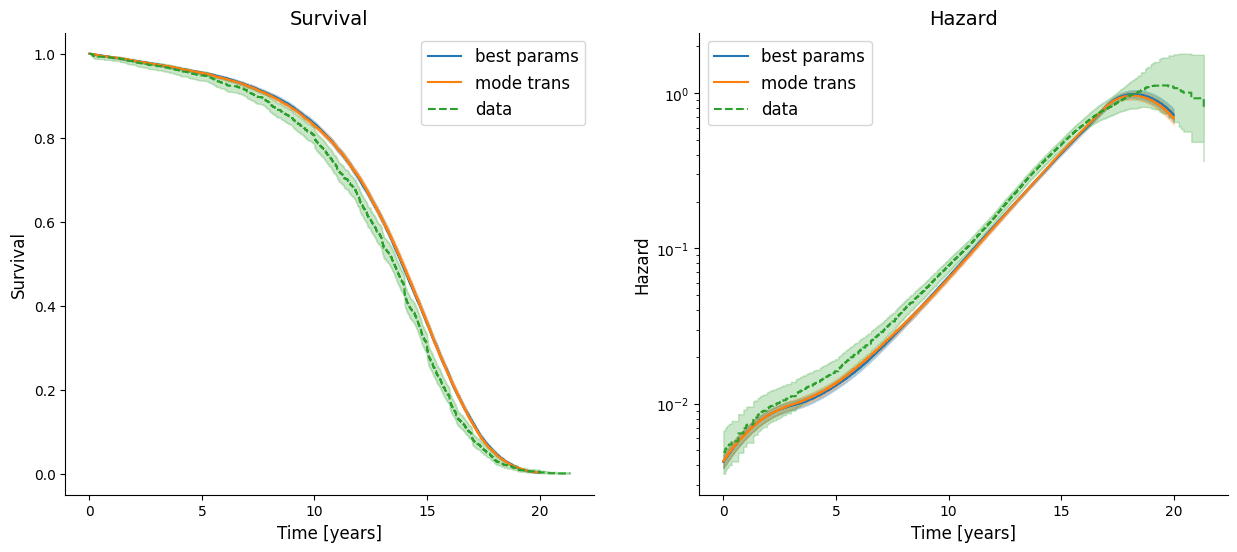

In [28]:
if not isinstance(post, jp.JointPosterior):
    # Define parameters for consistent styling
    TITLE_FONTSIZE = 14
    AXIS_FONTSIZE = 12
    LEGEND_FONTSIZE = 12


    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    # Plot survival on ax[0]
    ax0 = best_sim.plotSurvival(ax=axs[0],time_range=time_range, label='best params', 
                            title='Survival', xlabel=f'time [{TIME_UNIT}]', ylabel='survival')
    sim_mode_trans.plotSurvival(ax=ax0,time_range=time_range, label='mode trans')
    ds.plotSurvival(ax=ax0,time_range=time_range, label='data', linestyle='--')  # Made data dashed
    ax0.legend(fontsize=LEGEND_FONTSIZE)
    ax0.set_title('Survival', fontsize=TITLE_FONTSIZE)
    ax0.set_xlabel(f'Time [{TIME_UNIT}]', fontsize=AXIS_FONTSIZE)
    ax0.set_ylabel('Survival', fontsize=AXIS_FONTSIZE)

    # Plot hazard on ax[1]
    ax1 = best_sim.plotHazard(ax=axs[1], title='Hazard', xlabel=f'time [{TIME_UNIT}]', 
                            ylabel='hazard', label='best params')
    sim_mode_trans.plotHazard(ax=ax1, label='mode trans')
    ds.plotHazard(ax=ax1, label='data', linestyle='--')  # Made data dashed
    ax1.set_yscale('log')
    ax1.legend(fontsize=LEGEND_FONTSIZE)
    ax1.set_title('Hazard', fontsize=TITLE_FONTSIZE)
    ax1.set_xlabel(f'Time [{TIME_UNIT}]', fontsize=AXIS_FONTSIZE)
    ax1.set_ylabel('Hazard', fontsize=AXIS_FONTSIZE)

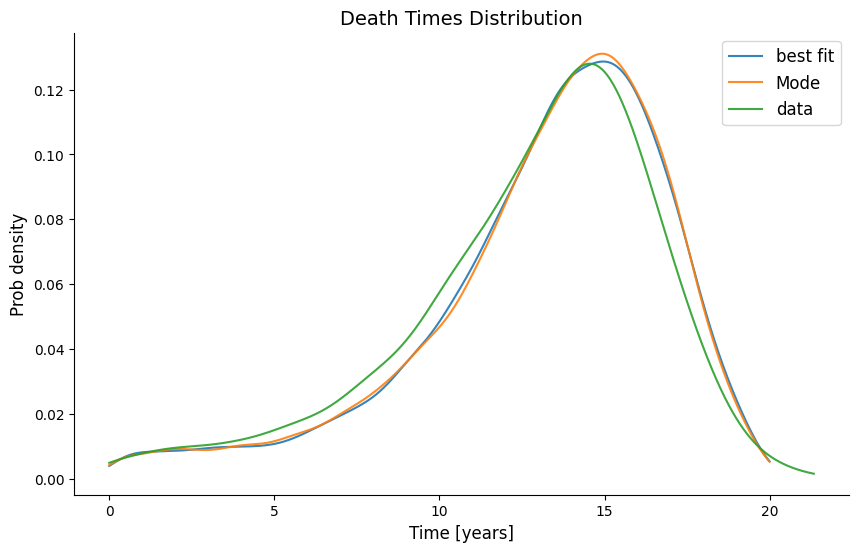

In [29]:
if not isinstance(post, jp.JointPosterior):
    #add plots of the death time distributions of the best fit and data:
    fig,ax = plt.subplots(1,1, figsize=(10,6))
    best_sim.plotDeathTimesDistribution(ax=ax,use_kde=True, label='best fit',alpha=0.9)
    sim_mode_trans.plotDeathTimesDistribution(ax=ax,use_kde=True, label='Mode',alpha=0.9)
    ds.plotDeathTimesDistribution(ax=ax,use_kde=True ,label='data',alpha=0.9)
    ax.legend(fontsize=LEGEND_FONTSIZE)
    ax.set_title('Death Times Distribution', fontsize=TITLE_FONTSIZE)
    ax.set_xlabel(f'Time [{TIME_UNIT}]', fontsize=AXIS_FONTSIZE)
    ax.set_ylabel('Prob density', fontsize=AXIS_FONTSIZE)
